# Neural network for classifying handwritten digits

Adapted (without permission!) from Octave code from programming assignment 3 from Coursera course [Neural Networks for Machine Learning](https://www.coursera.org/learn/neural-networks/) by Geoff Hinton

## Step 1

Read data stored in matlab binary file format file _data.mat_ and look at some of the data cases.

In [1]:
import scipy.io
import numpy as np

def loadmatfile(filename):
    '''Data stored in matlab binary format in nested objects (dictionaries)
    Pre-partitioned into training, validation and testing sets, each including
    inputs (16x16 pixel bitmaps of grayscale intensities) and targets (the digit
    being represented)
    
    Args:
        - filename (String)
        
    Returns:
        - dictionary with keys 'training', 'validations' and 'tesing',
        each with values dictionary with keys 'inputs' and 'targets' '''
    
    datafile = scipy.io.loadmat('data.mat')

    trobj = datafile['data'][0]['training']
    trdict = {}
    trdict['inputs'] = trobj[0]['inputs'][0][0]
    trdict['targets'] = trobj[0]['targets'][0][0]

    vobj = datafile['data'][0]['validation']
    vdict = {}
    vdict['inputs'] = vobj[0]['inputs'][0][0]
    vdict['targets'] = vobj[0]['targets'][0][0]

    teobj = datafile['data'][0]['test']
    tedict = {}
    tedict['inputs'] = teobj[0]['inputs'][0][0]
    tedict['targets'] = teobj[0]['targets'][0][0]

    data = {}
    data['training'] = trdict
    data['validation'] = vdict
    data['test'] = tedict

    return data

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import math

def getImage(data, index, shape=None):
    '''Visualize digit at index index in dataset data
    
    Args:
        - data (numpy array with columns containing pixel intensities)
        - index (column of digit to visualize)
        
    Returns:
        - matrix of pixel intensities
    '''
    # get row of pixel data
    img = data[:,index]
    if shape is None:
        side = int(math.sqrt(len(img)))
        img.shape = (side,side)
    else:
        img.shape = shape
    return img

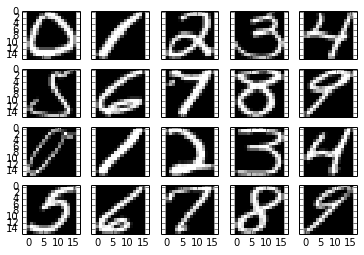

In [3]:
# read data from matlab file
data = loadmatfile('data.mat')

# display first 20 training digits
image_indices = range(20)
fig, axs = plt.subplots(int(math.ceil(1.0*len(image_indices)/5)), 5, \
                        sharex=True, sharey=True)
for ii, image_index in enumerate(image_indices):
    row = ii/5
    col = ii % 5
    ax = axs[row][col]
    ax.imshow(getImage(data['training']['inputs'],image_index), \
              cmap='gray', interpolation='nearest')
plt.show()

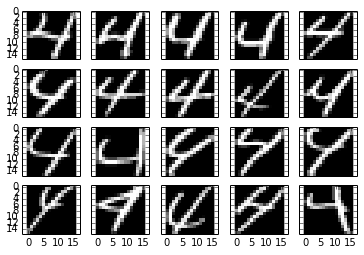

In [4]:
# display first 20 4's
image_indices = range(4,204,10)
fig, axs = plt.subplots(int(math.ceil(1.0*len(image_indices)/5)), 5, \
                        sharex=True, sharey=True)
for ii, image_index in enumerate(image_indices):
    row = ii/5
    col = ii % 5
    ax = axs[row][col]
    ax.imshow(getImage(data['training']['inputs'],image_index), \
              cmap='gray', interpolation='nearest')
plt.show()

## Step 2 - Design network

The network will consist of:

* Input layer with 256 nodes (one for each pixel in image)
    $$\mathbf{x} \in R^{256}$$
* Hidden layer with logistic activation function
    $$z^{(1)}_i = \sum_j^{N_{\mathrm{inp}}} W^{(1)}_{ij} x_j$$
    $$h_i = \frac{1}{1 + \exp\left(-z^{(1)}_i\right)}$$    
* Softmax output layer
    $$z^{(2)}_k = \sum_i^{N_{\mathrm{hid}}} W^{(2)}_{ki} h_i$$
    $$y_k = \frac{\exp\left(z^{(2)}_k\right)}{\sum\limits_l^{N_{\mathrm{outp}}}\exp\left(z^{(2)}_l\right)}$$

The loss function for training is the cross-entropy with L2 weight-penalty regularization:

$$L(\mathbf{y}) = - \frac{1}{N_{\mathrm{cases}}} \sum_i^{N_{\mathrm{cases}}}\sum_j^{N_{\mathrm{outp}}}t^{(i)}_j \log(y^{(i)}_j) + \frac{\lambda}{2}\left( \sum_i^{N_{\mathrm{hid}}}\sum_j^{N_{\mathrm{inp}}} {W^{(1)}_{ij}}^2 + \sum_i^{N_{\mathrm{outp}}}\sum_j^{N_{\mathrm{hid}}} {W^{(2)}_{ij}}^2 \right)$$

where $\lambda$ is the weight-decay penalty parameter and $t^{(i)}_j=\delta_{jk}$ if the $i$th target digit is a $k$.

### Step 3 - Construct and initialize weight matrices

The model object consists of the two two-dimensional arrays $W^{(1)}$ (size $N_{\mathrm{hid}} \times N_{\mathrm{inp}}$)
and $W^{(2)}$ (size $N_{\mathrm{outp}} \times N_{\mathrm{hid}}$).

Methods for converting model object to a 1-d array of coeficients $\theta$ and back again.

In [5]:
def model_to_theta(model):
    # This function takes a model (or gradient in model form) 
    # and turns it into one long vector (inverse of theta_to_model)
    return np.concatenate((model['input_to_hid'].flatten(), \
                           model['hid_to_class'].flatten()))

def theta_to_model(theta):
    # This function takes a model (or gradient) in the form of one long vector 
    # (maybe produced by model_to_theta), and restores it to the dictionary format,
    # i.e. with keys 'input_to_hid' and 'hid_to_class' both matrix-valued
    n_hid = len(theta) / (256+10)
    W1 = np.array(theta[:(256*n_hid)])
    W1.shape = (256, n_hid)
    W2 = np.array(theta[(256*n_hid):])
    W2.shape = (n_hid, 10) 
    model = {}
    model['input_to_hid'] = W1
    model['hid_to_class'] = W2
    return model

Method for initializing model with a cosine function (because why not)

In [6]:
def initial_model(n_hid):
    # initialize with a cosine function (can replace with random init)
    n_params = (256+10) * n_hid
    as_row_vector = 0.1 * np.cos(range(n_params))
    return theta_to_model(as_row_vector)


### Step 4 - Compute loss function

Helper functions for computing hidden layer, softmax function, and loss function:

In [7]:
def logistic(inp):
    return 1. / (1. + np.exp(-inp))

def log_sum_exp_over_rows(a):
    # computes log(sum(exp(a_i))) in a numerically stable way
    # find largest element in (each row of) a
    maxs_small = np.max(a, 0)
    # tile largest element in each column to construct matrix of size of a
    maxs_big = np.tile(maxs_small, [a.shape[0],1])
    return np.log(sum(np.exp(a - maxs_big))) + maxs_small

Compute loss function for a set of data cases and a given set of weights.

Note that the $\log$ of the softmax is computed directly, both for numerical stability and because it appears in the loss function:

$$ \log y_k = \log\frac{\exp\left(z^{(2)}_k\right)}{\sum\limits_l^{N_{\mathrm{outp}}}\exp\left(z^{(2)}_l\right)} = \log z^{(2)}_k - \log \sum_l^{N_{\mathrm{outp}}}\exp\left(z^{(2)}_l\right)$$

Note also that for numerical stability it is better to compute the log-sum term using:

$$\begin{align}
\log \sum_l^{N_{\mathrm{outp}}}\exp\left(z^{(2)}_l\right)
           &= \log \sum_l^{N_{\mathrm{outp}}}\frac{\exp(Z_\max)}{\exp(Z_\max)}\exp\left(z^{(2)}_l\right)\\ 
           &= \log \left[ \exp(Z_\max)\sum_l^{N_{\mathrm{outp}}}\exp\left(z^{(2)}_l-Z_\max\right) \right]\\
           &= Z_\max + \log \sum_l^{N_{\mathrm{outp}}}\exp\left(z^{(2)}_l-Z_\max\right)
\end{align}$$

where $Z_\max$ is the largest of the inputs to the softmax function.

In [8]:
def loss(model, data, wd_coefficient):
    # Forward pass through network
    # input to the hidden units, i.e. before the logistic (N_hid x N_cases)
    z1 = model['input_to_hid'].transpose().dot(data['inputs'])
    # output of the hidden units (N_hid x N_cases)
    h = logistic(z1)
    # input to softmax (N_outp x N_cases)
    z2 = model['hid_to_class'].transpose().dot(h)

    # Compute the log of the softmax
    class_normalizer = log_sum_exp_over_rows(z2)
    log_class_prob = z2 - np.tile(class_normalizer, [z2.shape[0],1])
    # Compute the probabilities of each class (not used)
    # class_prob = np.exp(log_class_prob)

    # compute the two terms in the loss function separately
    classification_loss = - np.mean(sum(log_class_prob * data['targets']))
    wd_loss = 0.5*wd_coefficient * sum(x**2 for x in model_to_theta(model))

    return classification_loss + wd_loss

### Step 5 - Compute gradient of loss function (aka back-propagation)

Compute the gradient from the loss function *backwards* to the inputs, reusing
results that can be reused.

Recall loss function:

$$\begin{align}
L(\mathbf{y}) &= - \frac{1}{N_{\mathrm{cases}}} \sum_i^{N_{\mathrm{cases}}}\sum_j^{N_{\mathrm{outp}}}t^{(i)}_j \log(y^{(i)}_j) + \frac{\lambda}{2}\left( \sum_i^{N_{\mathrm{hid}}}\sum_j^{N_{\mathrm{inp}}} {W^{(1)}_{ij}}^2 + \sum_i^{N_{\mathrm{outp}}}\sum_j^{N_{\mathrm{hid}}} {W^{(2)}_{ij}}^2 \right)\\
&\equiv \frac{1}{N_{\mathrm{cases}}}\sum_i^{N_{\mathrm{cases}}}L^{(i)}_{\mathrm{class}} + L_{\mathrm{reg}}
\end{align}$$

First, it is trivial to compute the gradient of $L_{\mathrm{reg}}$ with respect to the weights:

$$\begin{align}
\frac{\partial L_{\mathrm{reg}}}{\partial W^{(1)}_{jk}} &= \lambda W^{(1)}_{jk}\\
\frac{\partial L_{\mathrm{reg}}}{\partial W^{(2)}_{jk}} &= \lambda W^{(2)}_{jk}
\end{align}$$

Next let's calculate the gradient of the contribution to the classification loss from a single data case with respect to the inputs to the softmax:

$$\begin{align}
\frac{\partial L^{(i)}_{\mathrm{class}}}{\partial z_k^{(2)}} &= \frac{\partial}{\partial  z_k^{(2)}}\left[-\sum_j^{N_{\mathrm{outp}}}t_j \left(z_j^{(2)} - \log \sum_l^{N_{\mathrm{outp}}}\exp\left(z^{(2)}_l\right)\right)\right]\\
&= - t_k + \frac{\exp\left(z^{(2)}_k\right)}{\sum_l^{N_{\mathrm{outp}}}\exp\left(z^{(2)}_l\right)}
\end{align}
$$

whence

$$\frac{\partial L^{(i)}_{\mathrm{class}}}{\partial W_{kl}} = \frac{\partial L^{(i)}_{\mathrm{class}}}{\partial z^{(2)}_k} \frac{\partial z^{(2)}_k}{\partial W_{kl}}
= \frac{\partial L^{(i)}_{\mathrm{class}}}{\partial z^{(2)}_k} h_l$$

Continuing back through the network:

$$
\frac{\partial L^{(i)}_{\mathrm{class}}}{\partial z_m^{(1)}} = \sum_k^{N_{\mathrm{hid}}}\frac{\partial L^{(i)}_{\mathrm{class}}}{\partial z^{(2)}_k}\frac{\partial z^{(2)}_k}{\partial h_m}
\frac{\mathrm{d}h_m}{\mathrm{d}z_m^{(1)}} = \sum_k^{N_{\mathrm{hid}}}\frac{\partial L^{(i)}_{\mathrm{class}}}{\partial z^{(2)}_k}W^{(2)}_{km}
\frac{\mathrm{d}h_m}{\mathrm{d}z_m^{(1)}} = \sum_k^{N_{\mathrm{hid}}}\frac{\partial L^{(i)}_{\mathrm{class}}}{\partial z^{(2)}_k}W^{(2)}_{km}
h_m(1-h_m) 
$$

So that

$$
\frac{\partial L^{(i)}_{\mathrm{class}}}{\partial W_{ms}^{(1)}} = 
\frac{\partial L^{(i)}_{\mathrm{class}}}{\partial z_m^{(1)}}\frac{\partial z_m^{(1)}}{\partial W^{(1)}_{ms}} = \frac{\partial L^{(i)}_{\mathrm{class}}}{\partial z_m^{(1)}} x_s
= \sum_k^{N_{\mathrm{hid}}}\frac{\partial L^{(i)}_{\mathrm{class}}}{\partial z^{(2)}_k}W^{(2)}_{km}
h_m(1-h_m) x_s 
$$

Finally, to get the gradient of $L_{\mathrm{class}}$ with respect to $W^{(1)}_{ms}$ and $W^{(2)}_{kl}$, average the corresponding formulas over all data cases.

In [9]:
def d_loss_by_d_model(model, data, wd_coefficient):
    # Return object of same size and structure as model object but with
    # entries representing the partial derivative of the loss function with
    # respect to the corresponding weight

    ### Forward pass through network
    z1 = model['input_to_hid'].transpose().dot(data['inputs'])
    h = logistic(z1)
    z2 = model['hid_to_class'].transpose().dot(h)
    class_normalizer = np.exp(log_sum_exp_over_rows(z2))
    # get inverse number of data cases (for computing classification loss)
    nrows_inv = 1.0/(data['inputs'].shape[0])

    # gradient of loss function with respect to each input to softmax
    dL_dz2 = - data['targets'] + np.exp(z2) / np.tile(class_normalizer, [z2.shape[0],1])

    grad = {}
    # gradient of loss function with respect to elements of W2
    grad['input_to_hid'] = wd_coefficient * model['input_to_hid'] + \
            nrows_inv * ( (model['hid_to_class'].dot(dL_dz2)) \
            * ( h * (1 - h) ) ).dot(data['inputs'].transpose()).transpose()
    # gradient of loss function with respect to elements of W1
    grad['hid_to_class'] = wd_coefficient * model['hid_to_class'] + \
                           nrows_inv * (dL_dz2.dot(h.transpose())).transpose()

    return grad

### Step 6 - Train network!!!

Methods to traverse network forwards (compute outputs for a batch of inputs) and evaluate error rate, i.e. (1 - accuracy rate)

In [10]:
def traverse_network(model, data):
    z1 = model['input_to_hid'].transpose().dot(data['inputs'])
    h = logistic(z1)                
    z2 = model['hid_to_class'].transpose().dot(h)
    return z2

def classification_performance(model, data):
    # This returns the fraction of data cases that are incorrectly classified by the model
    class_input = traverse_network(model, data)
    correct = np.argmax(data['targets'],0)
    choices = np.argmax(class_input,0)
    return (1.0 - np.mean([choice == correct[i] for i,choice in enumerate(choices)]), \
            choices, correct)


In [11]:
def train(wd_coefficient, n_hid, n_iters, learning_rate, \
          momentum_multiplier, do_early_stopping, mini_batch_size):
    # create an initial model object
    model = initial_model(n_hid)
    # load the training, validation and test data
    datas = loadmatfile('data.mat')
    # number of training cases
    n_training_cases = datas['training']['inputs'].shape[1]

    ### optimization
    # convert weight matrices to a vector
    theta = model_to_theta(model)
    # set initial search "speed" through weight space to 0 (if using momentum)
    momentum_speed = 0 * theta
    # empty lists for collecting loss values
    training_data_losses = []
    validation_data_losses = []
    # if early stopping, keep track of best score so far on validation data
    if do_early_stopping:
        best_so_far = {}
        best_so_far['theta'] = -1
        best_so_far['validation_loss'] = 1.e50
        best_so_far['after_n_iters'] = -1
        
    # iterate n_iters times
    for optimization_iteration_i in range(n_iters):
        # convert weights vector to weight matrices
        model = theta_to_model(theta)

        # create batch of training cases, starting from end of last batch and wrapping
        # back around to the beginning when reaching the end
        training_batch = {}
        training_batch_start = np.mod((optimization_iteration_i) * mini_batch_size, \
                                      n_training_cases)
        training_batch_end = np.mod(training_batch_start + mini_batch_size, n_training_cases)
        if training_batch_end > training_batch_start:
            training_batch['inputs'] = datas['training']['inputs'][:, training_batch_start : training_batch_end]
            training_batch['targets'] = datas['training']['targets'][:, training_batch_start : training_batch_end]
        else:
            training_batch['inputs'] = np.concatenate((datas['training']['inputs'][:,training_batch_start:], \
                                                       datas['training']['inputs'][:,:training_batch_end]), 1)
            training_batch['targets'] = np.concatenate((datas['training']['targets'][:,training_batch_start:], \
                                                        datas['training']['targets'][:,:training_batch_end]), 1)

        # compute the gradient of the loss function with respect to weights
        gradient = model_to_theta(d_loss_by_d_model(model, training_batch, wd_coefficient))
        # update the speed through weight space
        momentum_speed = momentum_speed * momentum_multiplier - gradient
        # update weight vector
        theta = theta + momentum_speed * learning_rate
        # convert new weight vector to weight matrices
        model = theta_to_model(theta)
        # compute loss on entire training and validation sets and
        # append to lists keeping track
        training_data_losses.append( loss(model, datas['training'], wd_coefficient) )
        validation_data_losses.append( loss(model, datas['validation'], wd_coefficient) )
        # if using early stopping, compare loss on validation set to current best-so-far
        if (do_early_stopping):
            if (validation_data_losses[-1] < best_so_far['validation_loss']):
                best_so_far['theta'] = theta
                best_so_far['validation_loss'] = validation_data_losses[-1]
                best_so_far['after_n_iters'] = optimization_iteration_i
        
        # report after every 10% of the iterations
        if np.mod(optimization_iteration_i, int(n_iters/10)) == 0:
            print('After %d optimization iterations, training loss is %f, validation loss is %f' \
                    % (optimization_iteration_i, training_data_losses[-1], validation_data_losses[-1]))

    # if using early stopping, retrieve weights that yielded minimum validation loss
    if do_early_stopping:
        print('Early stopping: validation loss was lowest after %d iterations.  We chose the model that we had then.\n' \
                % (best_so_far['after_n_iters']))
        theta = best_so_far['theta']
    model = theta_to_model(theta)

    # plot training and validation loss as function of iteration
    if (n_iters != 0):
        plt.plot(training_data_losses, 'b')
        plt.plot(validation_data_losses, 'r')
        plt.legend(('training', 'validation'))
        plt.ylabel('loss')
        plt.xlabel('iteration number')
        plt.show()

    for data_name in ['training','validation','test']:
        data = datas[data_name]
        print('\nThe loss on the %s data is %f' % (data_name, loss(model, data, wd_coefficient)))
        if wd_coefficient:
            print('The classification loss (i.e. without weight decay) on the %s data is %f' % (data_name, loss(model, data, 0)))
        class_perf, choices, corrects = classification_performance(model, data)
        print('The classification error rate on the %s data is %f' % (data_name, class_perf))

    # return the model object
    return model

After 0 optimization iterations, training loss is 2.327678, validation loss is 2.327629
After 100 optimization iterations, training loss is 0.518586, validation loss is 0.626511
After 200 optimization iterations, training loss is 0.316132, validation loss is 0.453691
After 300 optimization iterations, training loss is 0.286034, validation loss is 0.439526
After 400 optimization iterations, training loss is 0.274424, validation loss is 0.433831
After 500 optimization iterations, training loss is 0.268686, validation loss is 0.430296
After 600 optimization iterations, training loss is 0.265394, validation loss is 0.427809
After 700 optimization iterations, training loss is 0.263269, validation loss is 0.425946
After 800 optimization iterations, training loss is 0.261760, validation loss is 0.424489
After 900 optimization iterations, training loss is 0.260613, validation loss is 0.423317
Early stopping: validation loss was lowest after 981 iterations.  We chose the model that we had then.

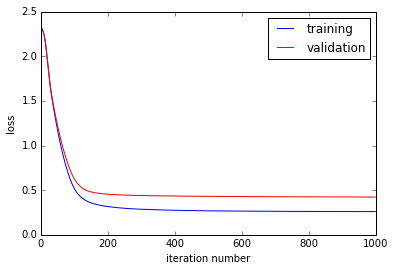


The loss on the training data is 0.259851
The classification loss (i.e. without weight decay) on the training data is 0.114983
The classification error rate on the training data is 0.003000

The loss on the validation data is 0.422523
The classification loss (i.e. without weight decay) on the validation data is 0.277655
The classification error rate on the validation data is 0.076000

The loss on the test data is 0.425565
The classification loss (i.e. without weight decay) on the test data is 0.280696
The classification error rate on the test data is 0.072889


In [12]:
# train a model with:
#  - weight decay coefficient 0.001
#  - 40 hidden nodes
#  - 1000 iterations
#  - gradient-descent learning rate 0.35
#  - momentum multiplier 0.9
#  - early stopping ON
#  - batch size 150 training cases per iteration

model = train(0.001, 40, 1000, 0.35, 0.9, True, 150)

### Incorrectly classified test samples

656 wrong out of  9000


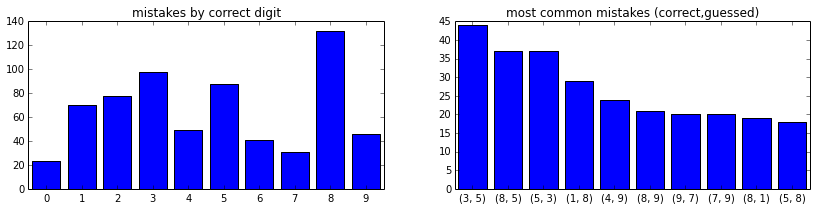

In [13]:
# classify test cases and compare to targets
class_perf, choices, corrects = classification_performance(model, data['test'])
wronguns = [(i,(corrects[i],x)) for i,x in enumerate(choices) if x != corrects[i]]

# count incorrectly classified samples
print len(wronguns), 'wrong out of ', len(data['test']['inputs'].transpose())

# break them down by digit:
by_correct_digit = [w[1][0] for w in wronguns]
counts_by_correct = [sum(n==k for k in by_correct_digit) for n in range(10)]

# find most common incorrect (correct,guessed) pairs
from collections import Counter
cntr = Counter([w[1] for w in wronguns])
most_common = cntr.most_common(10)

figure, axs = plt.subplots(1,2)
figure.set_figwidth(14)
figure.set_figheight(3)
axs[0].bar([a+0.1 for a in range(10)], counts_by_correct)
axs[0].set_xticks([a+0.5 for a in range(10)])
axs[0].set_xticklabels(range(10))
axs[0].set_title('mistakes by correct digit')

axs[1].bar([a+0.1 for a in range(len(most_common))], [mc[1] for mc in most_common])
axs[1].set_xticks([a+0.5 for a in range(len(most_common))])
axs[1].set_xticklabels([mc[0] for mc in most_common])
axs[1].set_title('most common mistakes (correct,guessed)')
plt.show()


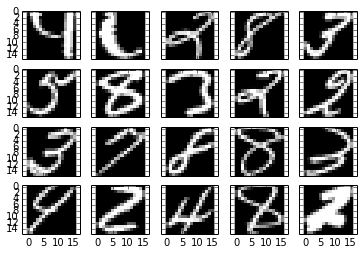

correct,guessed
4,9  1,6  2,4  8,5  3,8
5,3  8,5  3,7  2,9  2,3
3,2  7,9  8,1  8,3  3,2
4,8  2,8  4,6  8,1  2,1


In [14]:
# display first 20 incorrectuns
image_indices = [w[0] for w in wronguns[:20]]
fig, axs = plt.subplots(int(math.ceil(1.0*len(image_indices)/5)), 5, \
                        sharex=True, sharey=True)
for ii, image_index in enumerate(image_indices):
    row = ii/5
    col = ii % 5
    ax = axs[row][col]
    ax.imshow(getImage(data['test']['inputs'],image_index), \
              cmap='gray', interpolation='nearest')
plt.show()

# guesses:
print('correct,guessed')
for row in range(4):
    print('  '.join([str(wronguns[i][1][0]) + ',' + \
                     str(wronguns[i][1][1]) \
                     for i in range(5*row,5*(row+1))]))

### Images of different inputs in hidden units

For each digit, find the mean and standard deviation of value of each hidden unit

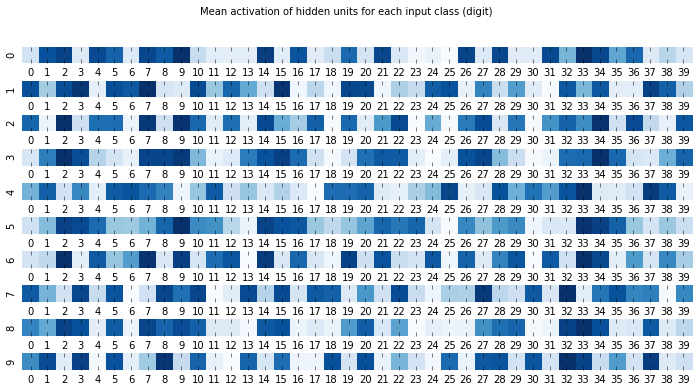

In [15]:
# for each digit, loop through training set and compute the values of the hidden units
hidden_means = []
hidden_stds = []
for i in range(10):
    inputs = data['training']['inputs'][:,i::10]
    z1 = model['input_to_hid'].transpose().dot(inputs)
    h = logistic(z1)
    hidden_means.append(h.mean(axis=1))
    hidden_stds.append(h.std(axis=1))
    
fig, axs = plt.subplots(10,1)
fig.set_figwidth(12)
fig.set_figheight(6)
for i,ax in enumerate(axs):
    img = hidden_means[i]
    img.shape = (1,len(img))
    ax.imshow(img, cmap='Blues', interpolation='nearest')
    ax.set_yticks([])
    ax.set_ylabel(str(i))
    ax.set_xticks(range(len(hidden_means[i][0])))
    ax.set_frame_on(False)
plt.suptitle('Mean activation of hidden units for each input class (digit)')
plt.show()